# SiPMs stats

In [1]:
from __future__ import print_function
import numpy as np
import tables as tb
import scipy as sc
import scipy.signal
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time
import os

import sensorFunctions as sns
print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

This notebook has been run last on 04/11/2016 at 18:49:05.


In [2]:
try:
    h5f.close()
except:
    pass

In [3]:
h5f = tb.open_file("/Users/Gonzalo/github/IC/data/run_2639.h5")
sipmrwf = h5f.root.RD.sipmrwf
sipmdf = sns.read_data_sensors(h5f.root.Sensors.DataSiPM)

/Users/Gonzalo/github/IC/data/run_2639.h5 (File) ''
Last modif.: 'Tue Nov  1 20:21:50 2016'
Object Tree: 
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/RD (Group) ''
/RD/pmtblr (EArray(0, 12, 48000), shuffle, zlib(4)) ''
/RD/pmtrwf (EArray(1050, 12, 48000), shuffle, zlib(4)) ''
/RD/sipmrwf (EArray(1050, 1792, 1200), shuffle, zlib(4)) ''
/Run (Group) ''
/Run/event_number (EArray(1050,), shuffle, zlib(4)) ''
/Run/runInfo (Table(1,)) ''
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1792,)) ''



In [ ]:
print(h5f)

In [ ]:
print(sipmdf)

# Baselines

In [4]:
def compute_baselines(evts):
    baselines = []
    for evt in evts:
        baselines.append(np.mean(evt, axis=1))
    return np.array(baselines).T

In [5]:
baselines = compute_baselines(sipmrwf)

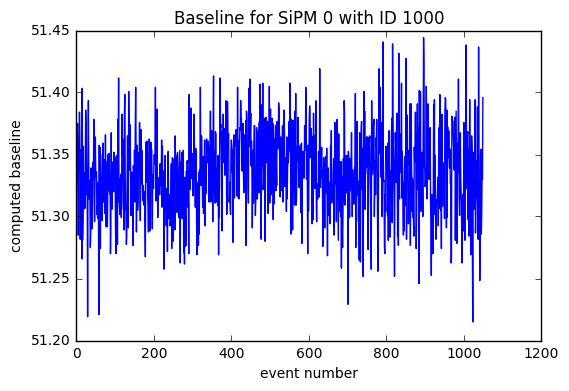

In [6]:
sipm = 0
plt.plot(baselines[sipm])
plt.xlabel("event number")
plt.ylabel("computed baseline")
plt.title("Baseline for SiPM {} with ID {}".format(sipm, sipmdf['channel'][sipm]))

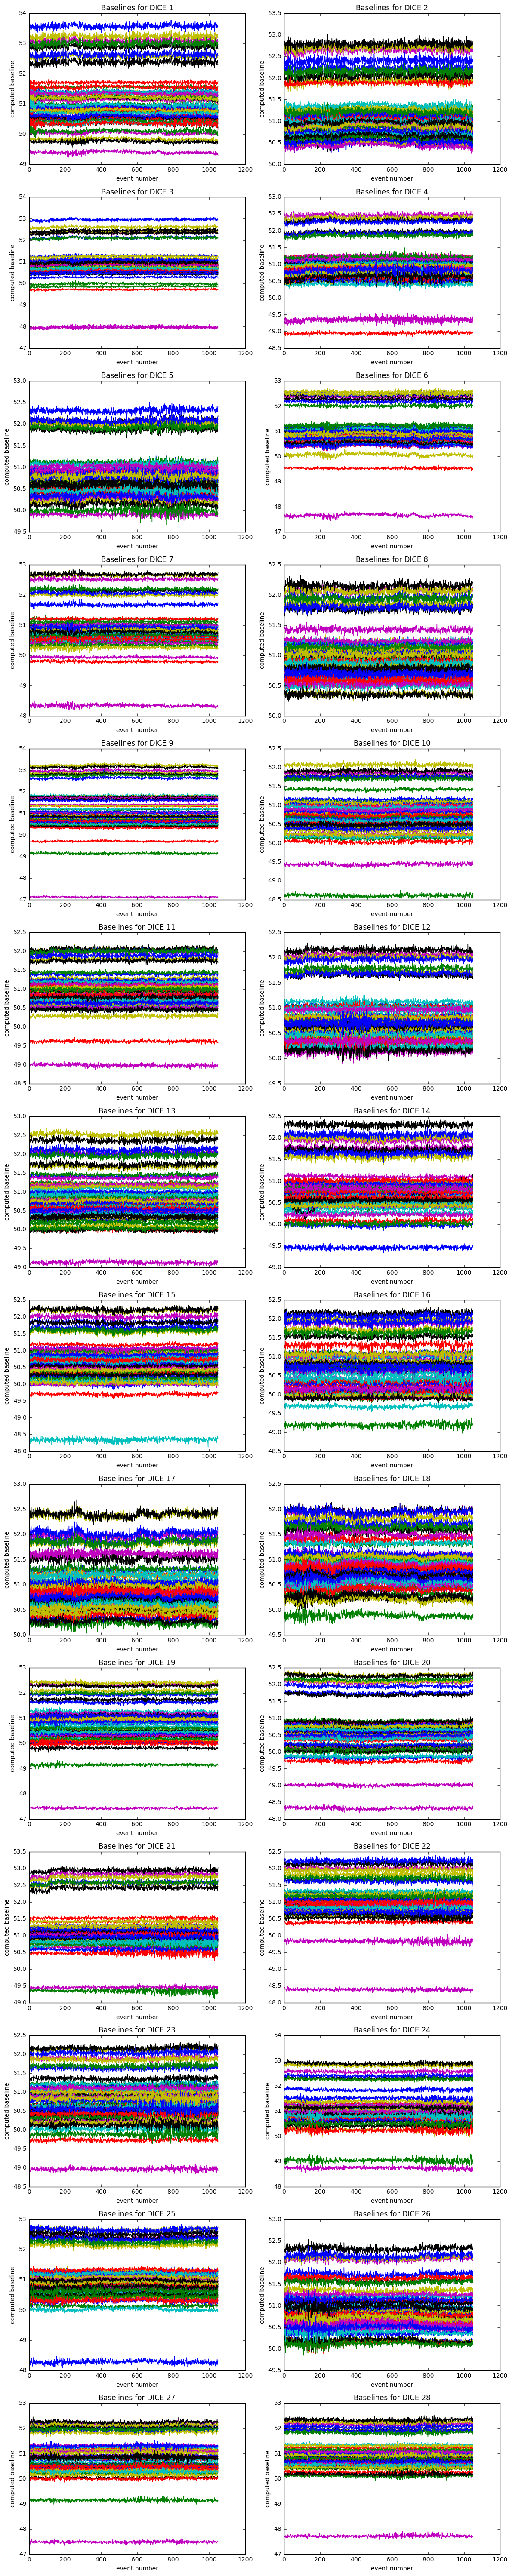

In [7]:
k = 0
fig, axes = plt.subplots(14,2)
fig.set_size_inches(12,60)
axes = axes.flatten()
for i in range(28):
    for j in range(64):
        if baselines[k].sum() > 0:
            axes[i].plot(baselines[k])
            axes[i].set_xlabel("event number")
            axes[i].set_ylabel("computed baseline")        
            axes[i].set_title("Baselines for DICE {}".format(i+1))
        k += 1
plt.tight_layout()

SiPM with greatest peak is at index 1716 with ID 27052.0


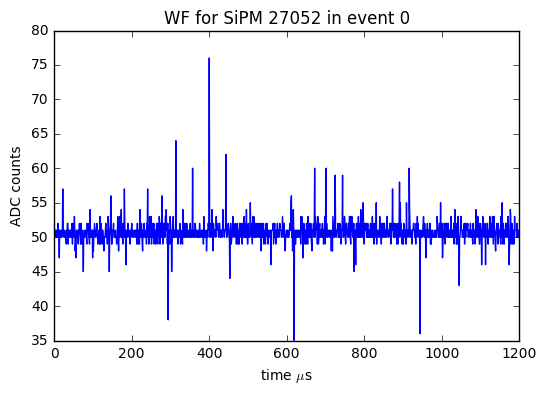

In [8]:
evt = 0
maxsipm = np.unravel_index(sipmrwf[evt].argmax(), sipmrwf[evt].shape)[0]
print("SiPM with greatest peak is at index {} with ID {}".format(maxsipm, sipmdf.ix[maxsipm].channel))

plt.plot(sipmrwf[0][maxsipm])
plt.xlabel("time $\mu$s")
plt.ylabel("ADC counts")
plt.title("WF for SiPM {} in event {}".format(sipmdf['channel'][maxsipm], evt))

# Noise

In [35]:
def subtract_baseline(wfs, mau_len = None):
    """
    Computes the baseline for each SiPM in the event and subtracts it.
    For doing so, the first mau_len samples in the waveform are taken.
    """
    baseline = lambda wf: sc.signal.lfilter(b_mau, 1, wf)[-1]
    if mau_len is None:
        mau_len = wfs.shape[1]
    b_mau = np.ones(mau_len)*1.0/mau_len
    bls = np.apply_along_axis(baseline, 1, wfs[:,:mau_len])
    return wfs - bls.reshape(wfs.shape[0],1)

def get_events(evts, n_split, max_evts=float('inf')):
    """
    Provides access to the evts.
    """
    i = 0
    for evt in evts:
        evt = subtract_baseline(evt, None)
        evt = [evt] if n_split==1 else np.split(evt, n_split, axis=1)
        for e in evt:
            yield i, e
            i += 1
            if i == max_evts:
                break
        if i == max_evts:
            break
        
def integrate_wfs(evts, n_split=1, max_evts=None):
    """
    Sums up the SiPMs waveforms.
    
    Parameters
    ----------
    evts: np.ndarray
        Array containing the waveform for each SiPM and each event.
    n_split: int (optional)
        Number of divisions to be performer to each waveform.
    """
#    if n_split>1:
#        evts = np.concatenate(np.split(evts, n_split, axis=2), axis=0)
#    sipm_integral = np.apply_along_axis(np.sum, 2, evts)
    if max_evts is None:
        max_evts = float('inf')
        sipm_integral = np.empty((evts.shape[0]*n_split, evts.shape[1]))
        print_mod = 10000
    else:
        sipm_integral = np.empty((max_evts, evts.shape[1]))
        print_mod = max_evts//10
    
    for i, evt in get_events(evts, n_split, max_evts):
        if not i%print_mod:
            print(i)
#        evt = subtract_baseline(evt, None)
        sipm_integral[i] = evt.sum(axis=1)
#        for j, sipm in enumerate(evt):
#            sipm_integral[i][j] = sipm.sum() if not np.argwhere(sipm>np.mean(sipm)+5*np.std(sipm)).any() else 0.
#    sipm_integral = [evt.sum(axis=1) for evt in get_events(evts, n_split)]
    return sipm_integral.T


### Noise distribution with 1-$\mu$s samples

In [36]:
sipms_noise_1mus = integrate_wfs(sipmrwf, 1200, 100000)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


6.6666666674e-05 1.67685823491


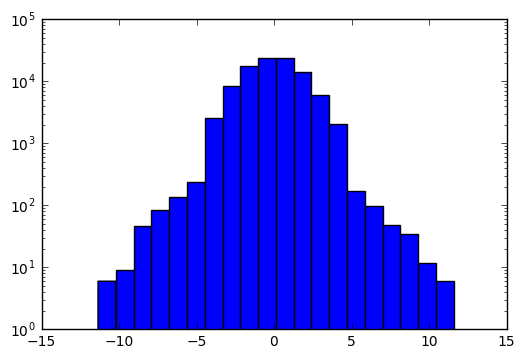

In [39]:
data = sipms_noise_1mus[0]
#data = data[data != 0.0]
#m = np.mean(data)
#r = np.std(data)
#low = m - 0.01*r
#upp = m + 0.03*r
#print(m, r, low, upp)

mu,sigma = sc.stats.norm.fit(data)

a = plt.hist(data, 20)#, range=(low,upp))
#gaus = mlab.normpdf(a[1], mu, sigma)
#plt.plot(a[1], gaus, 'r-', linewidth=2)
print(mu, sigma)
plt.yscale('log')

### Noise distribution with 1200 $\mu$s samples

In [44]:
sipms_noise_full = integrate_wfs(sipmrwf, 1, 1000)

0
100
200
300
400
500
600
700
800
900


5.07657636446e-12


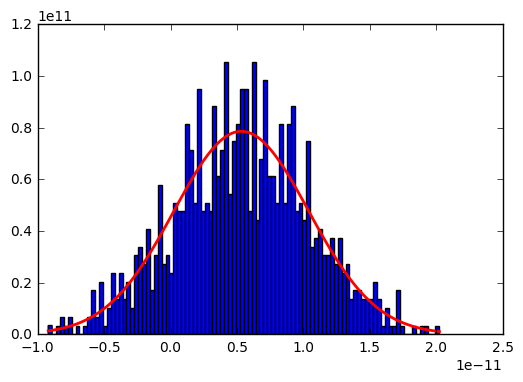

In [45]:
data = sipms_noise_full[100]
mu,sigma = sc.stats.norm.fit(data)

low = np.mean(data) - 5*np.std(data)
upp = np.mean(data) + 5*np.std(data)

#h = plt.hist(data.compressed(),100, range=(low,upp))
#h = plt.hist(data, 100, range=(low,upp), normed=True)
h = plt.hist(data, 100, normed=True)
gaus = mlab.normpdf(h[1], mu, sigma)
plt.plot(h[1], gaus, 'r-', linewidth=2)
print(np.std(data))

#plt.yscale('log')

# Signal - noise separation

In [46]:
h5sig = tb.open_file('/Users/Gonzalo/github/Shifts/data/run_2609.h5')
print(h5sig)

sipmsig  = h5sig.root.RD.sipmrwf

/Users/Gonzalo/github/Shifts/data/run_2609.h5 (File) ''
Last modif.: 'Thu Nov  3 18:37:49 2016'
Object Tree: 
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/RD (Group) ''
/RD/pmtblr (EArray(11284, 12, 48000), shuffle, zlib(4)) ''
/RD/pmtrwf (EArray(11284, 12, 48000), shuffle, zlib(4)) ''
/RD/sipmrwf (EArray(11284, 1792, 1200), shuffle, zlib(4)) ''
/Run (Group) ''
/Run/event_number (EArray(11284,), shuffle, zlib(4)) ''
/Run/runInfo (Table(1,)) ''
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1792,)) ''



In [47]:
def findmax(i, evt):
    if not i%1000: print(i)
    return np.max(subtract_baseline(evt))

In [48]:
maxq = [findmax(i,sipmsig[i]) for i in range(1000)]

0


In [53]:
os.system('say "Xa puto esta"')

0

In [50]:
data = np.ravel(sipms_noise_1mus)

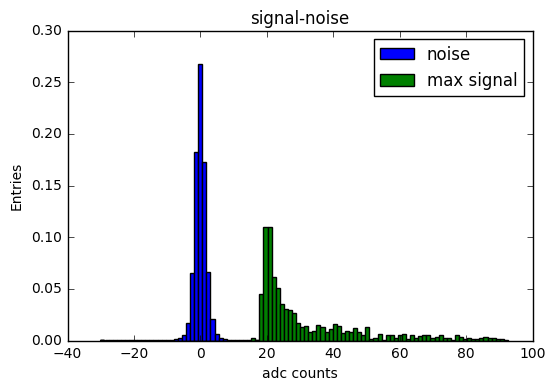

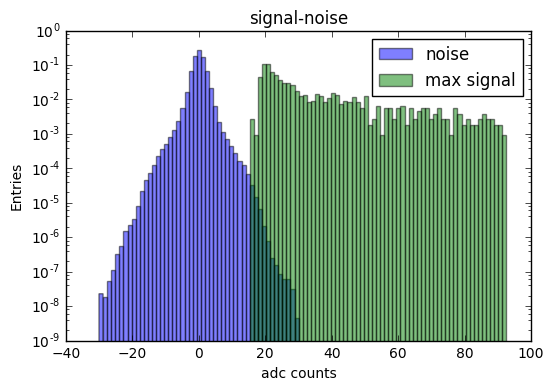

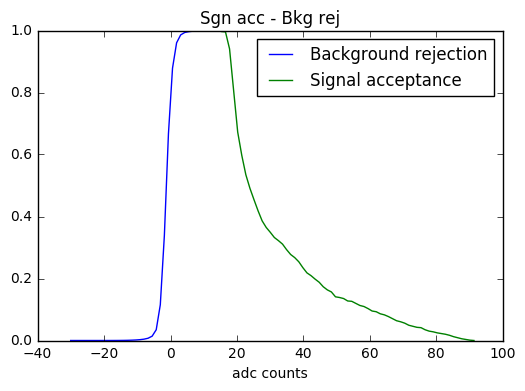

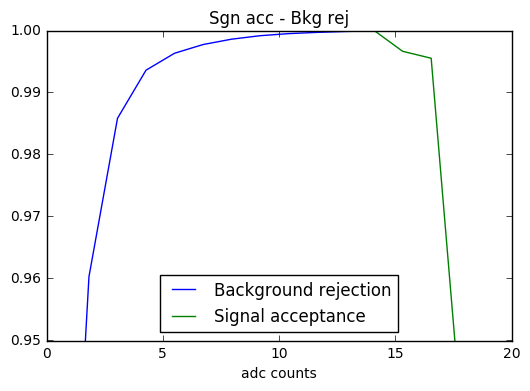

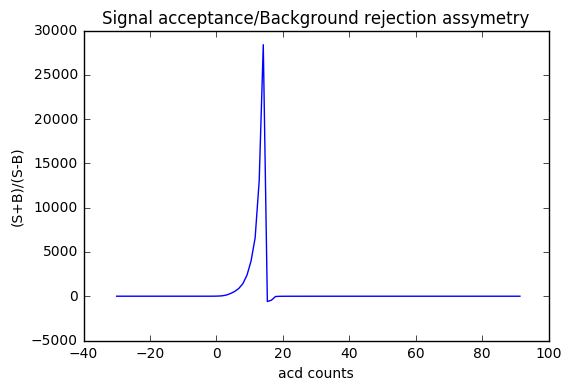

In [99]:
fig1 = plt.figure()
low, upp = np.min(data), np.mean(maxq) + 0.1*np.std(maxq)
a = plt.hist(data, 100, range=(low,upp), normed=True, label="noise")
b = plt.hist(maxq, 100, range=(low,upp), normed=True, label="max signal")
plt.xlabel("adc counts")
plt.ylabel("Entries")
plt.title("signal-noise")
plt.legend(loc='upper right')

fig2 = plt.figure()
low, upp = np.min(data), np.mean(maxq) + 0.1*np.std(maxq)
a = plt.hist(data, 100, range=(low,upp), normed=True, label="noise", alpha=0.5)
b = plt.hist(maxq, 100, range=(low,upp), normed=True, label="max signal", alpha=0.5)
plt.xlabel("adc counts")
plt.ylabel("Entries")
plt.yscale('log')
plt.title("signal-noise")
plt.legend(loc='upper right')

c = a[0].cumsum()
c /= c[-1]
d = b[0].cumsum()
d = 1. - d/d[-1]
x = a[1][:-1]

fig3 = plt.figure()
e = plt.plot(x, c, label='Background rejection')
e = plt.plot(x, d, label='Signal acceptance')
plt.xlabel("adc counts")
plt.title("Sgn acc - Bkg rej")
plt.legend(loc='upper right')

fig4 = plt.figure()
e = plt.plot(x, c, label='Background rejection')
e = plt.plot(x, d, label='Signal acceptance')
plt.xlim((0,20))
plt.ylim((0.95,1))
plt.xlabel("adc counts")
plt.title("Sgn acc - Bkg rej")
plt.legend(loc='lower center')

fig5 = plt.figure()
f = [(di+ci)/(di-ci) for ci, di in zip(c,d)]
g = plt.plot(x, f)
plt.xlabel("acd counts")
plt.ylabel("(S+B)/(S-B)")
plt.title("Signal acceptance/Background rejection assymetry")


# Tests and old stuff

In [ ]:

data = np.ma.masked_less(sipms_noise[0], -.5)
low = np.mean(data) - 2*np.std(data)
upp = np.mean(data) + 3*np.std(data)
h = plt.hist(data.compressed(),100, range=(low,upp))
plt.yscale('log')

In [ ]:
plt.plot(sipmrwf[1][0])

In [ ]:
plt.plot(h5f.root.RD.pmtrwf[0][1])

In [ ]:
data = sipmrwf[:1000][0].flatten()
a=plt.hist(data,30,range=(40,70))

In [ ]:
from scipy import signal
xs = np.arange(0, np.pi, 0.0005)
data = np.sin(12*xs)
peakind = signal.find_peaks_cwt(data, np.arange(1,10))
peakind, xs[peakind], data[peakind]

In [ ]:
plt.plot(xs, data)
plt.scatter(xs[peakind],data[peakind])